# <span style="color:red">  **SIMULATIONS ET MÉTHODES DE MONTE CARLO**  </span>

In [1]:
import numpy as np 
from scipy.stats import multivariate_normal
import Estimateurs
import Code
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Sommaire

- [Partie 0. Définition du cadre gaussien pour la génération des données](#partie-0-définition-du-cadre-gaussien-pour-la-génération-des-données)
  - [0.1. Génération du vrai $\theta$](#01-génération-du-vrai-theta)
  
  - [0.2. Génération de notre vecteur d'observation $\boldsymbol{x} \in \mathbb{R}^{20}$](#02-génération-de-notre-vecteur-dobservation-boldsymbolx-in-mathbbr20)

  - [0.3. Génération de la vraie log-vraisemblance et du vrai gradient associé à $\theta_{\text{true}}$ et à notre observation $\boldsymbol{x}$](#03-génération-de-la-vraie-log-vraisemblance-et-du-vrai-gradient-associé-à-thetatru-et-à-notre-observation-boldsymbolx)

  - [0.4. Génération des paramètres de l'encodeur $A \in \mathbb{R}^{20\times 20}$ et $b \in \mathbb{R}^{20}$](#04-génération-des-paramètres-de-lencodeur-a-in-mathbbr2020-et-b-in-mathbbr20)

- [Partie 1. Comparaison des estimateurs de la vraisemblance du modèle](#partie-1-comparaison-des-estimateurs-de-la-vraisemblance-du-modèle)

  - [1.1 Les estimateurs RR (Roulette Russe) et SS (Single Sample)](#11-les-estimateurs-rr-roulette-russe-et-ss-single-sample)

    - [1.1.1 Estimateur ML-SS](#111-estimateur-ml-ss)

    - [1.1.2 Estimateur ML-RR](#112-estimateur-ml-rr)
    
  - [1.2 L'estimateurs SUMO (Stochastically Unbiased Marginalization Objective (SUMO))](#12-lestimateurs-sumo-stochastically-unbiased-marginalization-objective-sumo)

  - [1.3 L'estimateurs IWAE (Autoencoder Pondéré par l'Importance)](#13-lestimateurs-iwae-autoencoder-pondéré-par-limportance)
  
  - [1.4 Comparaison entre les différents estimateurs](#14-comparaison-entre-les-différents-estimateurs)

<span style="color:blue">  **NOTATIONS**  </span> : on se donne un ensemble de données $\boldsymbol{x} = \{x^{(i)}\}_{i=1}^n$ composé de $n$ échantillons i.i.d. d'une variable continue ou discrète $x$ à valeurs dans un espace d'observations $\boldsymbol{\mathcal{X}}$ (ainsi $\boldsymbol{x} \in \boldsymbol{\mathcal{X}}$). Nous supposons que les données sont générées par un processus aléatoire impliquant une variable aléatoire continue non observée $\boldsymbol{z} = \{z^{(i)}\}_{i=1}^n$ à valeur dans un espace d'observations $\boldsymbol{\mathcal{Z}}$ (ainsi $\boldsymbol{z} \in \boldsymbol{\mathcal{Z}}$). Le processus se compose de deux étapes :


1. La valeur $z^{(i)}$ est générée à partir d'une distribution a priori $p_{\theta^*}(z)$ ;
2. Une valeur $x^{(i)}$ est générée à partir d'une distribution conditionnelle $p_{\theta^*}(x|z)$.


Nous supposons que la distribution a priori $p_{\theta^*}(\boldsymbol{z})$ et la vraisemblance $p_{\theta^*}(\boldsymbol{x}|\boldsymbol{z})$ proviennent de familles paramétriques de distributions $p_{\theta}(\boldsymbol{z})$ et $p_{\theta}(\boldsymbol{x}|\boldsymbol{z})$ et on note $\Theta \subset \mathbb{R}^d$ l'espace des paramètres. On connait ainsi l'expression de ces deux distributions. En revanche une grande partie de ce processus nous est cachée : les véritables paramètres $\theta^*$ ainsi que les valeurs des $\textbf{variables latentes}$ $z^{(i)}$ nous sont inconnus. 

Connaissant l'expression de la distribution a priori $p_{\theta^*}(\boldsymbol{z})$ et la vraisemblance $p_{\theta^*}(\boldsymbol{x}|\boldsymbol{z})$ pour tout $\theta \in \Theta$, on peut définir la densité jointe $p_{\theta}(\boldsymbol{x}, \boldsymbol{z})$ sur $\boldsymbol{\mathcal{X}} \times \boldsymbol{\mathcal{Z}}$ par : 

$$
p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = p_{\theta}(\boldsymbol{x}|\boldsymbol{z}) p_{\theta}(\boldsymbol{z})
$$

<span style="color:blue">  **OBJECTIF**  </span> : on cherche à déterminer la vraie valeur du paramètre (ici $\theta^*$) ainsi que les valeurs des variables latentes. 

Une approche classique pour apprendre $\boldsymbol{\theta}$ est de choisir, si celle-ci existe, la valeur de ce paramètre qui maximise la log-vraisemblance marginale de l’ ́echantillon définie par :

$$
\ell(\boldsymbol{\theta}) = \log p_{\boldsymbol{\theta}}(\boldsymbol{x}) = \log \int_{\boldsymbol{\mathcal{Z}}} p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z}) d\boldsymbol{z}
$$

<span style="color:blue">  **PROBLÈME**  </span> : l'intégrale donnée en ci-dessus est intractable (nous ne pouvons donc pas évaluer ou différencier la vraisemblance marginale).

<span style="color:blue">  **SOLUTION**  </span> : dans le but de résoudre les problèmes ci-dessus, introduisons un **modèle de reconnaissance** (paramétrique) {$ q_{\phi}(\boldsymbol{z}|\boldsymbol{x}) : \phi \in \Phi$} avec $\Phi \subset \mathbb{R}^d$. Pour tout $\phi$, $q_{\phi}(\boldsymbol{z}|\boldsymbol{x})$ est choisi comme une approximation de la véritable postérieure intractable $p_{\theta}(\boldsymbol{z}|\boldsymbol{x})$. L'idée est donc de proposer une valeur de l'a posteriori (faire une hypothèse) et d'introduire une méthode pour apprendre les paramètres du **modèle de reconnaissance** $\phi$ conjointement avec les paramètres du **modèle génératif** $\theta$.

## <span style="color:green">  **Partie 0. Définition du cadre gaussien pour la génération des données**  </span>

(Application numérique inspirée de [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf))

- Le **modèle génératif** est donné par $p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = \mathcal{N}(\boldsymbol{z}|\theta, I) \mathcal{N}(\boldsymbol{x}|\boldsymbol{z}, I)$, où $\boldsymbol{x}$ et $\boldsymbol{z} \in \mathbb{R}^{20}$, de sorte que $p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta, 2I)$ et $p_{\theta}(\boldsymbol{z}|\boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$. 

- La **distribution de l'encodeur** (le modèle de reconnaissance) est $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$, où $\phi = (A, b)$.

- Nous considérons des perturbations aléatoires des paramètres près de la valeur optimale par une distribution gaussienne de moyenne nulle et d'écart-type $0.01$.

**Dans ce cas, on peut analytiquement calculer la vraie log-vraisemblance du modèle pour quantifier le biais et la variance de tous les estimateurs**.

Puisque $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$ est censé être une approximation de la véritable loi a posteriori donnée par $p_{\boldsymbol{\theta}}(\boldsymbol{z} | \boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$

### <span style="color:orange"> 0.1. **Génération du vrai $\theta$**  </span>

On commence par tirer le $\theta$* ($\in \mathbb{R}$) qui sera le paramètre que l'on cherchera à estimer par la suite. 

A la manière de la génération des données dans [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf) : $\theta^* \sim \mathcal{N}(0, 1)$

In [2]:
#theta_true = np.random.multivariate_normal(np.zeros(20), np.identity(20))
theta_true = np.random.normal(0, 1)
print(f"La valeur de theta à estimer est {int(theta_true*100)/100}")

La valeur de theta à estimer est 1.31


### <span style="color:orange"> 0.2. **Génération de notre vecteur d'observation $\boldsymbol{x} \in \mathbb{R}^{20}$**  </span>

L'idée est désormais de tirer une observation $\boldsymbol{x} \in \mathbb{R}^{20}$, chose que l'on peut faire puisque toutes les distributions nous sont données. 


In [3]:
## On se donne notre échantillon x

x, _ = Estimateurs.joint_probability(theta_true)

print(f"L'échantillon x observé est :\n \n x = {x} \n \n et on vérifique bien sa taille est celle voulue : {x.shape}")

L'échantillon x observé est :
 
 x = [3.90670162 0.48752527 1.55519913 1.05881461 0.56085143 1.42698351
 3.55888651 2.75905409 0.94247992 0.37644927 2.32651945 0.88935057
 1.20167783 0.49656479 3.14093468 2.10568512 1.37545773 4.30416266
 0.20712124 1.9612803 ] 
 
 et on vérifique bien sa taille est celle voulue : (20,)


### <span style="color:orange"> 0.3. **Génération de la vraie log-vraisemblance et du vrai gradient associé à $\theta_{\text{true}}$ et à notre observation $\boldsymbol{x}$**  </span>

On rappelle que l'on nous a donné que $p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta, 2I)$ pour tout $\boldsymbol{x} \in \mathbb{R}^{20}$, ainsi, on peut explicitement calculer la log-vraisemblance et du vrai gradient de $p_{\theta}$ par rapport à $\theta$. On a :

\begin{align*}
\ell (\theta) = \log p_{\theta}(\boldsymbol{x}) = \log (\mathcal{N}(\boldsymbol{x}|\theta, 2I)) &= \log \left ( \frac{1}{\sqrt{(2\pi)^{20} \det(2I)}} \exp \left\{-\frac{1}{2} (x-\theta\bm{1}_{20})^T (2I)^{-1} (x-\theta\bm{1}_{20}) \right\} \right )\\
&= \log \left ( \frac{1}{(2\pi)^{10} 2^{10}} \exp \left\{-\frac{1}{4} (x-\theta\bm{1}_{20})^T (x-\theta\bm{1}_{20}) \right\} \right )\\
&= - 10 \log (4\pi) -\frac{1}{4} (x-\theta\bm{1}_{20})^T (x-\theta\bm{1}_{20})\\
&= - 10 \log (4\pi) -\frac{1}{4} \| x - \theta \mathbf{1}_{20} \|^2\\
&= - 10 \log (4\pi) -\frac{1}{4} \sum_{i=1}^{20} (x_i - \theta)^2

\end{align*}

Et, alors 

\begin{align*}
\nabla_{\theta}\ell (\theta) = \ell '(\theta) &= \frac{1}{2} \sum_{i=1}^{20} (x_i - \theta)\\
&= \frac{1}{2} \sum_{i=1}^{20}x_i - 10 \theta \\
&= 10 \frac{1}{20} \sum_{i=1}^{20}x_i - 10 \theta \\
&= 10 (\bar{x}_{20} - \theta)
\end{align*}

In [4]:
true_likelihood = Code.true_likelihood(x, theta_true)
true_gradient = Code.true_grad(x, theta_true)

print(f"La valeur associée à la log-vraisemblance de l'échantillon x pour theta_true est : {true_likelihood} \n ")
print(f"La valeur associée au gradient de l'échantillon x pour theta_true est : \n\n {true_gradient} \n ")

La valeur associée à la log-vraisemblance de l'échantillon x pour theta_true est : -26.9114785877841 
 
La valeur associée au gradient de l'échantillon x pour theta_true est : 

 4.211566906553346 
 


### <span style="color:orange"> 0.4. **Génération des paramètres de l'encodeur $A \in \mathbb{R}^{20\times 20}$ et $b \in \mathbb{R}^{20}$**  </span>

Il est maintenant question de tirer notre encodeur tel que : $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$, où $\phi = (A, b)$. **Le problème qui se pose est donc celui du choix de $A$ et de $b$**. Dans l'article [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf), il nous est indiqué : 

*"Following [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf), we consider random perturbations of the parameters near the optimal value by a zero-mean Gaussian with standard deviation 0.01"*

Ainsi, étant donné une observation $\boldsymbol{x}$,  le choix parfait pour $\phi$ serait $\phi^* = (A^*, b^*)$ où $A^* = \frac{1}{2}\boldsymbol{I}_{20} \in \mathbb{R}^{20 \times 20}$ et $b^* = [\frac{\theta^*}{2}, ..., \frac{\theta^*}{2}]^T \in \mathbb{R}^{20} $. Suivant l'indication dans l'article, nous nous plaçons dans un cas où on aurait réussi à inférer de manière convenable la loi $p_{\theta}(\boldsymbol{z}|\boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$, mais pas parfaitement. Ainsi,  on introduit de la même façon que dans l'article [[Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf) une perturbation autour de la valeur optimale du paramètre $\phi$. Cette perturbation se caractérise par le fait chaque dimension de chaque paramètre a été décalée de manière aléatoire par rapport à sa valeur optimale en utilisant une gaussienne centrée en zéro avec un écart-type de 0,01.


In [5]:
dim = 20 

## On calcule les valeurs optimales de A et de b
A = 0.5 * np.eye(dim)
b = 0.5 * theta_true * np.ones(dim)

## On calcule les valeurs perturbées de A et de b, qui sont FIXÉES dans la suite
noised_A, noised_b = Code.noised_params(A, b)

print(f"On vérifie que les tailles de A, b et x coincident :\n \n taille A : {A.shape} \n taille b : {b.shape} \n taille x : {x.shape}")

On vérifie que les tailles de A, b et x coincident :
 
 taille A : (20, 20) 
 taille b : (20,) 
 taille x : (20,)


## <span style="color:green">  **Partie 1. Comparaison des estimateurs de la vraisemblance du modèle**  </span>

### <span style="color:orange">  **1.1 Les estimateurs RR (Roulette Russe) et SS (Single Sample)**  </span>

On rappelle rapidement la manière dont sont définis les estimateurs RR et SS, utilisés plus tard pour construire SUMO, ML-SS et ML-RR.  
Désignons une quantité d'intérêt par $I_\infty = \log p_\theta(\boldsymbol{x})$. Supposons que $I_\infty$ puisse être écrite comme

$$
I_\infty = \mathbb{E}[I_0] + \sum_{k=0}^\infty \mathbb{E}[\Delta_k] 
$$

pour les variables aléatoires $I_0$ et $(\Delta_k)_{k\geq0}$. Nous pouvons estimer $I_\infty$ de manière non biaisée via les estimateurs suivants ss ou rr :

$$
ss = I_0 + \frac{\Delta_K}{p(K)}, \quad rr = I_0 + \sum_{k=0}^K \frac{\Delta_k}{\mathbb{P}(K \geq k)}
$$

où $K \sim Geom(r)$.

Pour chacun de ces estimateurs, nous allons suivre la méthodologie du Monte Carlo multiniveau (voir cet [article](https://web.stanford.edu/~glynn/papers/2015/BlanchetG15.html)) qui repose sur un schéma alternatif astucieux pour construire $\Delta_k$, qui peut garantir la construction d'estimateurs non biaisés de $\ell(\boldsymbol{\theta})$ qui admettent une variance finie et peuvent être calculés en un temps attendu fini.

Nous désignons par $\boldsymbol{z}^O_i$, $\boldsymbol{z}^E_i$ deux séquences indépendantes d'échantillons i.i.d. de $q_\phi$, où $O$, $E$ désignent respectivement impair (odd), pair (even), et $w^O_i$, $w^E_i$ les poids d'importance correspondants. Ensuite, nous définissons $I_0 = \hat{\ell}^{(1)}(\boldsymbol{\theta})$ et

\begin{align*}
\Delta^\text{ML}_k = \hat{\ell}^{(2^{k+1})}_{O\cup E}(\boldsymbol{\theta}) - \frac{1}{2} \left( \hat{\ell}^{(2^k)}_O (\boldsymbol{\theta}) + \hat{\ell}^{(2^k)}_E (\boldsymbol{\theta}) \right),
\end{align*}

où $\hat{\ell}^{(2^k)}_O (\boldsymbol{\theta}) = \log \left(\frac{1}{2^k} \sum_{i=1}^{2^k} w(z^{O}_i) \right)$ est calculé en utilisant les échantillons impairs $\{z^O_i\}_{i=1}^{2^k}$, $\hat{\ell}^{(2^k)}_E (\boldsymbol{\theta}) = \log \left(\frac{1}{2^k} \sum_{i=1}^{2^k} w(z^{E}_i) \right)$ en utilisant les échantillons pairs $\{z^E_i\}_{i=1}^{2^k}$, et $\hat{\ell}^{(2^{k+1})}_{O\cup E} (\boldsymbol{\theta})$ en utilisant $\{z^O_i\}_{i=1}^{2^k} \cup \{z^E_i\}_{i=1}^{2^k}$. Nous désignons les estimateurs SS/RR multiniveaux correspondants de $\hat{\ell}(\boldsymbol{\theta})$ comme $\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta})$ et $\hat{\ell}^\text{ML-RR}(\boldsymbol{\theta})$, et collectivement comme $\hat{\ell}^\text{ML}(\boldsymbol{\theta})$.

Ainsi, 

$$
\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta}) = I_0 + \frac{\Delta^{\text{ML}}_\mathcal{K}}{p(\mathcal{K})}, \quad \hat{\ell}^\text{ML-RR}(\boldsymbol{\theta}) = I_0 + \sum_{k=0}^{K} \frac{\Delta^{\text{ML}}_k}{\mathbb{P}(\mathcal{K} \geq k)},
$$

En abscisse, on considère un segment centré autour de $\theta^*$, la vraie valeur du paramètre. Pour chaque point de ce segment, on calcule l'estimation réalisée par $\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta})$ ou $\hat{\ell}^\text{ML-RR}(\boldsymbol{\theta})$ et on la trace sur les graphiques suivant. Le courbe en rouge représente la vraie fonction de vraisemblance, calculée analytiquement. 

#### <span style="color:red">  **1.1.1 Estimateur ML-SS**  </span>

On choisit arbitrairement un nombre de 15 simulations et de 60 points pour des questions de vitesse de calcul. 

In [6]:
n_simulations = 15 
num_runs = 10
r = 0.6
#k_IWAE = 5 

Progression:   0%|          | 0/30 [00:00<?, ?it/s]

Progression: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


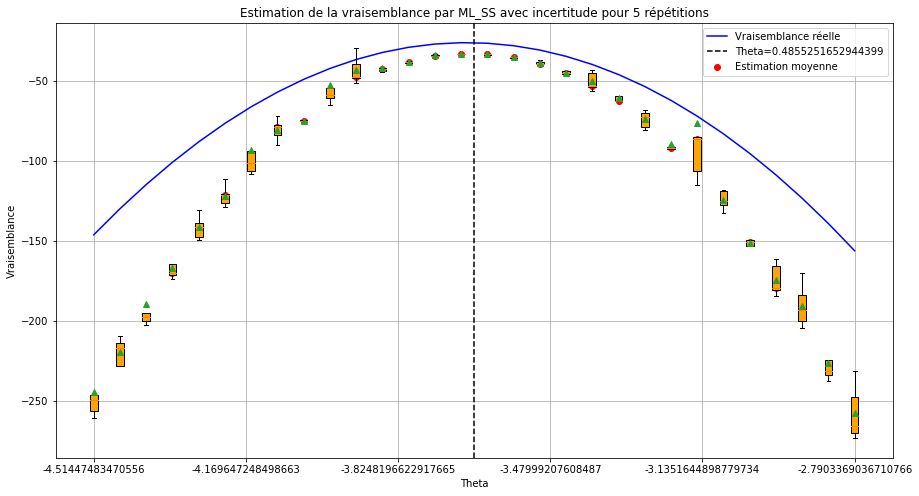

In [8]:
Code.plot_errors_likelihood(r, theta_true, x, noised_A, noised_b, n_simulations, 5, 'ML_SS')

In [ ]:
#On remarque c'est beaucoup plus long en important depuis le .py 
Code.plot_likelihood(r, x, noised_A, noised_b, theta_true, n_simulations, "ML_SS")

Progression: 100%|██████████| 60/60 [00:22<00:00,  2.62it/s]


On va désormais s'intéresser à l'estimation de $\nabla_{\theta} l(\theta)$ par notre estimateur ML-SS. L'objectif étant de voir à quel point cet estimateur nous permettra, par la suite, d'approximer $\theta^*$ à l'aide d'une descente de gradient. 

De la même façon, 

In [10]:
Code.plot_gradient(0.6, x, noised_A, noised_b, theta_true, n_simulations,'ML_SS')

#### <span style="color:red">  **1.1.2 Estimateur ML-RR**  </span>

In [ ]:
n_simulations = 15
r = 0.6

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true, n_simulations, "ML_RR")

Progression: 100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


In [9]:
Code.plot_gradient(0.6, x, noised_A, noised_b, theta_true, 15, "ML_RR")

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:254: RuntimeWarning:

divide by zero encountered in log

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:258: RuntimeWarning:

divide by zero encountered in log

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:256: RuntimeWarning:

divide by zero encountered in log

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:257: RuntimeWarning:

divide by zero encountered in log



### <span style="color:orange">  **1.2 L'estimateurs SUMO (Stochastically Unbiased Marginalization Objective (SUMO))**  </span>

On pose 
\begin{align*}
\Delta^{\text{SUMO}}_k &:= \hat{\ell}^{(k+2)}(\boldsymbol{\theta}) - \hat{\ell}^{(k+1)}(\boldsymbol{\theta})\\
&:= \log \left( \frac{1}{k+2} \sum_{i=1}^{k+2} w(\boldsymbol{z}_i) \right) - \log \left( \frac{1}{k+1} \sum_{i=1}^{k+1} w(\boldsymbol{z}_i) \right),
\end{align*}

où on rappelle que $w(\boldsymbol{z}) := \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z})}{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}$.

On applique l'estimateur $RR$ pour construire notre estimateur, que nous appelons $\textbf{SUMO}$ (Stochastically Unbiased Marginalization Objective) qui correspond précisément à l'estimateur de la roulette russe pour $\Delta^{\text{SUMO}}_k$. Ainsi, 
$$
\hat{\ell}^{\text{SUMO}}(\boldsymbol{\theta}) := I_0 + \sum^K_{k=0} \frac{\Delta^{\text{SUMO}}_k}{P(\mathcal{K} \geq k)}
$$
    
où $\mathcal{K} \sim p(\cdot)$ une distrubtion de support dans $\mathbb{N}$

In [ ]:
n_simulations = 15 
r = 0.6

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true, n_simulations, "SUMO")

Progression: 100%|██████████| 60/60 [00:18<00:00,  3.25it/s]


In [8]:
Code.plot_gradient(0.6, x, noised_A, noised_b, theta_true, 15, 'SUMO')

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:185: RuntimeWarning:

divide by zero encountered in log



### <span style="color:orange">  **1.3 L'estimateurs IWAE (Autoencoder Pondéré par l'Importance)**  </span>

Voir l'article séminal sur l'IWAE [ici](https://arxiv.org/pdf/1509.00519.pdf).

L'IWAE utilise cette architecture avec à la fois un **réseau génératif** (paramètre $\boldsymbol{\theta}$) et un **réseau de reconnaissance** (paramètre $\phi$). **La différence est qu'il est entraîné à maximiser une autre borne inférieure** sur $\log p_{\boldsymbol{\theta}}(\boldsymbol{x})$. En particulier, nous utilisons la borne inférieure suivante, correspondant à l'estimation de pondération d'importance à $k$ échantillons de la log-vraisemblance :

\begin{align*}
\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi) &= \mathbb{E}_{\boldsymbol{z}_1,\dots,\boldsymbol{z}_k \underset{i.i.d}{\sim} q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}\left[\log \frac{1}{k} \sum_{i=1}^{k} \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z}_i)}{q_{\phi}(\boldsymbol{z}_i | \boldsymbol{x})}\right ]
\end{align*}

Ici, $\boldsymbol{z}_1, \dots, \boldsymbol{z}_k$ sont échantillonnés indépendamment du modèle de reconnaissance. Le terme à l'intérieur de la somme correspond aux poids d'importance non normalisés pour la distribution conjointe, que nous noterons $w_i = \frac{p(\boldsymbol{x}, \boldsymbol{z}_i)}{q_{\phi}(\boldsymbol{z}_i | \boldsymbol{x})}$. 

L'optimisation de $\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)$ est effectuée conjointement en $\boldsymbol{\theta}$ et $\phi$. 

Il existe deux propriétés de l'IWAE qui nous permettront de le modifier pour produire un estimateur non biaisé :
1. Il est consistant, i.e. lorsque le nombre d'échantillons $k$ augmente, l'espérance de $\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)$ converge vers $\log p_{\boldsymbol{\theta}}(\boldsymbol{x})$ : 
$$
\log p_{\boldsymbol{\theta}}(\boldsymbol{x}) = \lim_{k \rightarrow +\infty} \mathbb{E}[\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)]
$$

2. Il est également croissant en espérance : 
$$
\mathbb{E}[\ell_{\text{IWAE}}^{(k+1)}(\boldsymbol{\theta}, \phi)] \geq \mathbb{E}[\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)]
$$ 

De la même façon que pour les estimateurs précédents, on trace les estimations de l'IWAE sur une plage autour de $\theta^*$

In [8]:
n_simulations = 15 
k_IWAE = 20
r = 0.6

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true,  n_simulations, k_IWAE, "IWAE")

Progression:   0%|          | 0/60 [00:00<?, ?it/s]

Progression: 100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Fixons k_IWAE = 5 et comparons les résultats : 

In [ ]:
k_IWAE = 5

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true,  n_simulations, k_IWAE, "IWAE")

Progression:   0%|          | 0/60 [00:00<?, ?it/s]

Progression: 100%|██████████| 60/60 [00:05<00:00, 11.55it/s]


In [7]:
Code.plot_gradient(r, x, noised_A, noised_b, theta_true, n_simulations, 'IWAE')

### <span style="color:orange">  **1.4 Comparaison entre les différents estimateurs**  </span>

Dans cette partie, nous allons comparer les estimateurs sur un même graphique. 

In [ ]:
Code.plot_likelihood(r, x, noised_A, noised_b, theta_true, n_simulations, "all")

Progression: 100%|██████████| 60/60 [02:06<00:00,  2.11s/it]


On fait de même pour le gradient : 

In [ ]:
Code.plot_gradient(r, x, noised_A, noised_b, theta_true, n_simulations, 'all')

## <span style="color:green">  **Partie 2. Analyse du Biais et de la Variance des estimateurs**  </span>

Dans cette partie, nous allons comparer les différents estimateurs de la vraisemblance et du gradient en termes de Biais et de Variance (Figure 2 dans la Section de 9 de [l'article](https://proceedings.mlr.press/v130/shi21d.html)).

Le biais d'un estimateur de la vraisemblance $ \ell({\theta})$ est donné par : ${\displaystyle {\text{Biais}}({\hat \ell({\theta })})\equiv \mathbb {E} [{\hat \ell ({\theta }})]-\ell(\theta) }$.

La variance d'un estimateur de la vraisemblance $ \ell({\theta})$ est donné par : $ \text{Var}(\hat\ell({\theta})) = \mathbb{E}\left[(\hat\ell({\theta}) - \mathbb{E}[\hat\ell({\theta})])^2 \right]$

A partir de ces formules, nous allons tracer le biais au carré de l'estimation de la log-vraisemblance pour chacune des méthodes. En abscisse, nous opérerons comme dans l'article et nous ferons varier le coût computationnel espéré. C'est-à-dire que nous ferons varier la taille de l'échantillon $z_i \underset{i.i.d}{\sim} q_{\phi}(\cdot|x)$ pour $i = 1, ..., k$. 

On rappelle que, pour les estimateurs SUMO, ML_SS et ML_RR, la taille de cet échantillon est tirée aléatoirement et dépend de : $\mathcal{K} \sim p(\cdot)$ une distrubtion de support dans $\mathbb{N}$. Pour des raisons de clarté et de vitesse de calcul, nous calculerons successivement le biais au carré des estimateurs pour des échantillons de taille $i = 1, ..., k$. 

Dans notre cas, $K \sim \text{Geom}(r)$ et donc opérer de cette manière est équivalent à ce qui est réalisé dans l'article où les auteurs font varier l'"expected computational cost". Cette unité est en fait l'ordre de grandeur du nombre d'opérations pour calcul de l'estimateur selon la taille de l'échantillon, soit $O(2^{k+1})$. Ainsi, faire varier cette unité entre 4 et 256 revient à faire varier $k$ de 1 à 7, ce que nous allons faire : 

In [7]:
Code.plot_bias_likelihood(x, theta_true, noised_A, noised_b, 7, 100)

Progression:   0%|          | 0/28 [00:00<?, ?it/s]

 
 Étape : 1 / 7 



Progression SUMO (3 échantillons):   0%|          | 0/100 [00:00<?, ?it/s]

Progression:  14%|█▍        | 4/28 [00:07<00:41,  1.73s/it]

 
 Étape : 2 / 7 



Progression:  29%|██▊       | 8/28 [00:16<00:41,  2.06s/it]

 
 Étape : 3 / 7 



Progression:  43%|████▎     | 12/28 [00:26<00:39,  2.48s/it]

 
 Étape : 4 / 7 



Progression:  57%|█████▋    | 16/28 [00:41<00:37,  3.16s/it]

 
 Étape : 5 / 7 



Progression:  71%|███████▏  | 20/28 [01:00<00:34,  4.35s/it]

 
 Étape : 6 / 7 



Progression:  86%|████████▌ | 24/28 [01:32<00:26,  6.62s/it]

 
 Étape : 7 / 7 



Progression: 100%|██████████| 28/28 [02:24<00:00,  5.17s/it]


Variance de la log-vraisemblance : 

In [7]:
Code.plot_variance_likelihood(x, theta_true, noised_A, noised_b, 9, 100, 10)

Progression:   0%|          | 0/36 [00:00<?, ?it/s]

 
 Étape : 1 / 9 



Progression:   3%|▎         | 1/36 [01:14<43:25, 74.44s/it]

 
 Étape : 2 / 9 



Progression:  14%|█▍        | 5/36 [02:43<15:28, 29.94s/it]

 
 Étape : 3 / 9 



Progression:  25%|██▌       | 9/36 [04:39<13:15, 29.45s/it]

 
 Étape : 4 / 9 



Progression:  36%|███▌      | 13/36 [07:29<13:29, 35.20s/it]

 
 Étape : 5 / 9 



Progression:  47%|████▋     | 17/36 [11:03<13:23, 42.29s/it]

 
 Étape : 6 / 9 



Progression:  58%|█████▊    | 21/36 [16:52<14:33, 58.22s/it]

 
 Étape : 7 / 9 



Progression:  69%|██████▉   | 25/36 [25:54<15:26, 84.24s/it]

 
 Étape : 8 / 9 



Progression:  81%|████████  | 29/36 [42:03<15:49, 135.57s/it]

 
 Étape : 9 / 9 



Progression: 100%|██████████| 36/36 [1:18:52<00:00, 131.46s/it]


Biais au carré de l'estimateur du gradient

In [8]:
Code.plot_bias_gradient(x, theta_true, noised_A, noised_b, 8, 100)

Progression:   0%|          | 0/32 [00:00<?, ?it/s]

 
 Étape : 1 / 8 



Progression SUMO (3 échantillons): 100%|██████████| 100/100 [00:02<00:00, 48.28it/s]


ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

Variance de l'estimateur du gradient : 

In [ ]:
Code.plot_variance_gradient(x, theta_true, noised_A, noised_b, 8, 100, 10)